# Augment the Data

Let us augment the items(movie) data with more fields from IMDB and / or TMDB data

In [1]:
import numpy as np
import pandas as pd
import json, glob
import requests
import re
import tmdb
from importlib import reload
from reco.recoutils import create_directory, update_progress

## Get the Movie Features from TMDB

- We will use the "links.csv" which contains:
    - movie_id
    - imdb_id
    - tmdb_id
- Source: Scraper + Manual Enhancement
     - Bootstrapped using the scraper to get the IMDB title link
     - Enhanced through search on TMDB database to get complete list

In [2]:
links = pd.read_csv("links.csv", dtype={"tmdb_id": 'Int64' })

In [3]:
links.head()

,movie_id,imdb_id,tmdb_id
0,1,tt0114709,862
1,2,tt0113189,710
2,3,tt0113101,5
3,4,tt0113161,8012
4,5,tt0112722,1710


In [4]:
links.shape

(1682, 3)

## Get Movie Feature from TMDB 

In [5]:
# sample_id = links.tmdb_id[5]
# tmdb.movie(sample_id)

In [6]:
tmdb_ids = links.tmdb_id.tolist()

In [7]:
def get_movie_features(tmdb_ids):
    num = len(tmdb_ids)
    tick = 0
    features = []
    for i in tmdb_ids:
        feature = tmdb.movie(i)
        if feature != False: 
            features.append(feature)
        
        tick = tick + 1
        update_progress(tick / num)
    
    update_progress(1)
    return features

In [8]:
def save_movie_features(features):
    outfile = "data/features.json"
    with open(outfile, 'w') as fout:
            json.dump(features, fout)

In [9]:
# Uncomment and Run this to download movie features from tmdb

#features = get_movie_features(tmdb_ids)
#save_movie_features(features)

## Create Item Features Augment

In [10]:
df_features = pd.read_json("data/features.json")
#df_features = pd.DataFrame.from_dict(features)

In [11]:
# Select the non NA links
links_full = links[~links.tmdb_id.isna()][["movie_id", "tmdb_id"]]

In [12]:
df_item_features = pd.merge(left=df_features, right=links_full, left_on="id", right_on="tmdb_id", how="left")

In [13]:
df_item_features.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movie_id,tmdb_id
0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.9,10878,1,862
1,False,/dA9I0Vd9OZzRQ2GyGcsFXdKGMz3.jpg,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,...,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.8,2037,2,710
2,False,/3EqYpbGCE9S5GddU2K4cYzP5UmI.jpg,None,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",None,5,tt0113101,en,Four Rooms,...,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,6.1,1251,3,5
3,False,/g1BfxcnplYEveGqS1ttfhdRBgbR.jpg,"{'id': 91698, 'name': 'Chili Palmer Collection...",30250000,"[{'id': 35, 'name': 'Comedy'}, {'id': 53, 'nam...",None,8012,tt0113161,en,Get Shorty,...,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The mob is tough, but it’s nothing like show b...",Get Shorty,False,6.5,501,4,8012
4,False,/gE1DHa82NZVb9B2Lx2cLNz43Iwd.jpg,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",None,1710,tt0112722,en,Copycat,...,124.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One man is copying the most notorious killers ...,Copycat,False,6.5,424,5,1710


In [14]:
df_item_features.to_csv("data/item_features.csv", index=None)

## Get Movie Posters

In [15]:
# Create Poster Directory
create_directory("/data/posters")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/data/posters


In [16]:
def poster(movie_id, df):
    """
    Gets the movie poster from the movie_id
    
    poster_path (string): path for the poster
    df (pd.Dataframe): pandas dataframe with movie id and poster_path
    """
    directory_path = "data/posters/"    
    poster_path = df[df.movie_id == movie_id].poster_path.values[0]
    if poster_path == None:
        poster_path = ""
    
    save_path = directory_path + str(movie_id) + ".jpg"
    
    base_url = "https://image.tmdb.org/t/p/w92"
    url = base_url + poster_path   
    
    response = requests.request("GET", url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as out_file:
            response.raw.decode_content = True 
            shutil.copyfileobj(response.raw, out_file)
        return True
    else: 
        return False

In [17]:
#df_item_features[df_item_features.poster_path.isna()][["movie_id", "poster_path"]]

In [18]:
import shutil

In [19]:
poster(1, df_item_features)

True

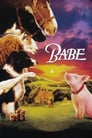

In [20]:
from IPython.display import Image 
Image(filename='data/posters/8.jpg')

In [21]:
def get_all_posters(df):
    """
    Get all posters from the dataframe and save with movie_id
    """
    id_list = df.movie_id.tolist()
    num = len(id_list)
    tick = 0
    
    for i in id_list:
        df["image"] = poster(i, df)
        tick = tick + 1
        update_progress(tick / num)
    
    update_progress(1)
    return df

In [22]:
# Uncomment and run this to get posters
# get_all_posters(df_item_features)